[View in Colaboratory](https://colab.research.google.com/github/sthalles/blog-resources/blob/master/sagan/Eager_SAGAN.ipynb)

In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
tf.enable_eager_execution()
import matplotlib.pyplot as plt
from keras.datasets import cifar10


1.8.0


Using TensorFlow backend.


In [2]:
# x_train, x_test: uint8 array of RGB image data with shape (num_samples, 3, 32, 32).
# y_train, y_test: uint8 array of category labels (integers in range 0-9) with shape (num_samples,).
(X_train, y_train), (X_test, y_test) = cifar10.load_data() 
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)

print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train data shape: (50000, 32, 32, 3)
Train labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


Number of classes: 10


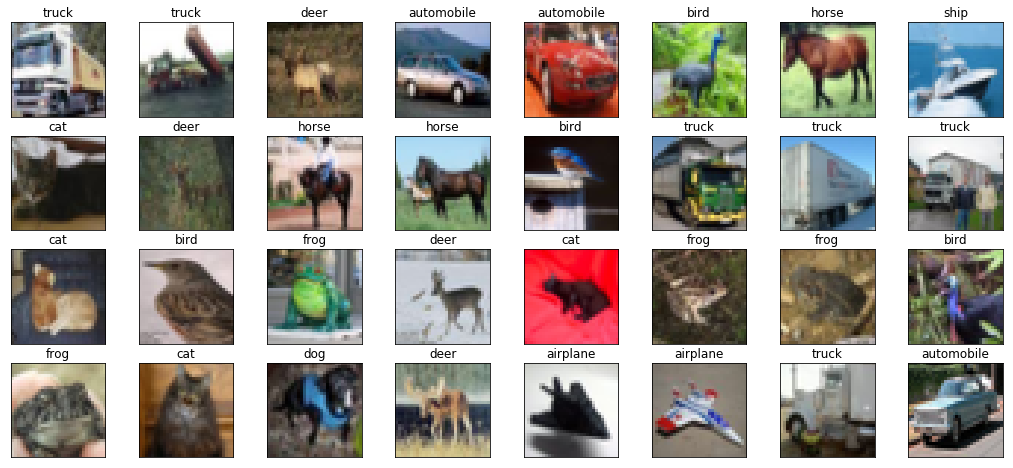

In [3]:
cifar_10 = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

n_classes = len(cifar_10)
print("Number of classes:", n_classes)


fig = plt.figure(figsize=(18,8))
n_columns = 8
n_rows = 4

for i in range(1,n_columns*n_rows+1):
  fig.add_subplot(n_rows, n_columns, i)
  plt.imshow(X_train[i])
  plt.title(cifar_10[y_train[i]])
  # Turn off tick labels
  plt.xticks([])
  plt.yticks([])
plt.show()

In [4]:
tfe = tf.contrib.eager

In [5]:
# # simulate conv filter
# w = tfe.Variable(tf.truncated_normal(shape=[3, 3, 16, 32])) # (3, 3, 16, 32)
# print("w:", w.shape)

# u = tfe.Variable(tf.truncated_normal(shape=[1,w.shape[-1]])) # (1, 32)
# print("u:", u.shape)

# w_reshape = tf.reshape(w, (-1, w.shape[-1])) # (144, 32)
# print("w_reshape:", w_reshape.shape)

# wu = tf.matmul(u, tf.transpose(w_reshape)) # (1, 144)
# print("wu:", wu.shape)
# v = wu / tf.nn.l2_normalize(wu)
# print("v:", v.shape)

# wv = tf.matmul(v, w_reshape)
# u = wv / tf.nn.l2_normalize(wv)
# print("u:", u.shape)

# # Calculate WSN with the spectral norm
# sigma = tf.matmul(tf.matmul(v, w_reshape), tf.transpose(u))
# WSN = w_reshape / sigma
# print("WSN:", WSN.shape)

# WSN = tf.reshape(WSN, w.shape)
# print("WSN:", WSN.shape)

In [6]:
class SelfAttention(tf.keras.Model):
  def __init__(self, number_of_filters):
    super(SelfAttention, self).__init__(number_of_filters)
    
    self.f = tf.keras.layers.Conv2D(number_of_filters//8, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.g = tf.keras.layers.Conv2D(number_of_filters//8, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.h = tf.keras.layers.Conv2D(number_of_filters, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.gamma = tfe.Variable(0.0, dtype=tf.float32) 
    self.flatten = tf.keras.layers.Flatten()
    
  def call(self, x):
    input_shape = tf.shape(x)
    f = self.f(x)
    g = self.g(x)
    h = self.h(x)
    
    f_flatten = self.flatten(f)
    g_flatten = self.flatten(g)
    h_flatten = self.flatten(h)
    
    s = tf.matmul(g_flatten, f_flatten, transpose_b=True)
    B = tf.nn.softmax(s)

    o = tf.matmul(B, h_flatten)
    
    y = self.gamma * o + self.flatten(x)
    return tf.reshape(y, input_shape)

![alt text](images/sngan_network_architecture.png)

In [7]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    # define the generator's layers
    
    self.fc1 = tf.keras.layers.Dense(units=4*4*512, activation="relu")
    
    # Deconvolution layer. Resulting image shape: (batch, 8, 8, 256)
    self.transp_conv1 = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding="SAME", activation=None)
    
    # BN + ReLU
    self.bn1 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation1 = tf.keras.layers.Activation(activation='relu')
    
    # resulting shape: (batch, 16, 16, 128)
    self.transp_conv2 = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding="SAME", activation=None)
    
    # BN + ReLU
    self.bn2 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation2 = tf.keras.layers.Activation(activation='relu')
    
    # pass the number of filters of the current feature volume
    self.attention = SelfAttention(128)
    
    # resulting shape: (batch, 32, 32, 3)
    self.transp_conv3 = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding="SAME", activation=None)
    
    self.bn3 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation3 = tf.keras.layers.Activation(activation='relu')
    
    self.conv = tf.keras.layers.Conv2D(3, 3, strides=1, padding='SAME', activation=None)
    self.out = tf.keras.layers.Activation(activation='tanh')
    
  def call(self, z, is_training):

    fc1 = self.fc1(z)
    fc1_reshaped = tf.reshape(fc1, (-1,4,4,512))

    trans_conv1 = self.transp_conv1(fc1_reshaped) # output shape [None,8,8,256]
    bn1 = self.bn1(trans_conv1, training=is_training)
    activation1 = self.activation1(bn1)

    transp_conv2 = self.transp_conv2(activation1) # output shape [None,16,16,128]
    bn2 = self.bn2(transp_conv2, training=is_training)
    activation2 = self.activation2(bn2)
    
    attention = self.attention(activation2)
    
    transp_conv3 = self.transp_conv3(attention) # output shape [None,32,32,3]
    bn3 = self.bn3(transp_conv3, training=is_training)
    activation3 = self.activation3(bn3)
    
    conv = self.conv(activation3)
    output = self.out(conv)
    
    return output

In [8]:
class Discriminator(tf.keras.Model):
  def __init__(self, alpha):
    super(Discriminator, self).__init__()
    
    # -------- Block 1
    self.conv1 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='SAME', activation=None)
    self.activation1 = tf.keras.layers.LeakyReLU(alpha=alpha)
  
    self.conv2 = tf.keras.layers.Conv2D(64, 4, strides=2, padding='SAME', activation=None)
    self.activation2 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    # pass the number of filters of the current feature volume
    self.attention = SelfAttention(64)
    
    # -------- Block 2
    self.conv3 = tf.keras.layers.Conv2D(128, 3, strides=1, padding='SAME', activation=None)
    self.activation3 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.conv4 = tf.keras.layers.Conv2D(128, 4, strides=2, padding='SAME', activation=None)
    self.activation4 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    # -------- Block 3
    self.conv5 = tf.keras.layers.Conv2D(256, 3, strides=1, padding='SAME', activation=None)
    self.activation5 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.conv6 = tf.keras.layers.Conv2D(256, 4, strides=2, padding='SAME', activation=None)
    self.activation6 = tf.keras.layers.LeakyReLU(alpha=alpha)
    # --------
    
    self.conv7 = tf.keras.layers.Conv2D(512, 3, strides=1, padding='SAME', activation=None)
    self.activation7 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(units=1, activation=None)
    
  
  def call(self, inputs, is_training):

    conv1 = self.conv1(inputs)
    activation1 = self.activation1(conv1)
        
    conv2 = self.conv2(activation1)
    activation2 = self.activation2(conv2)
    
    attention = self.attention(activation2)

    conv3 = self.conv3(attention)
    activation3 = self.activation3(conv3)
    
    conv4 = self.conv4(activation3)
    activation4 = self.activation4(conv4)
    
    conv5 = self.conv5(activation4)
    activation5 = self.activation5(conv5)
    
    conv6 = self.conv6(activation5)
    activation6 = self.activation6(conv6)
    
    conv7 = self.conv7(activation6)
    activation7 = self.activation7(conv7)
    
    flat = self.flatten(activation7)
    logits = self.fc1(flat)
    return logits

In [9]:
z_size = 128
learning_rate_generator = 0.0001
learning_rate_discriminator = 0.0004
batch_size = 128
alpha = 0.1
beta1 = 0.0
beta2 = 0.9

In [10]:
generator_net = Generator()
discriminator_net = Discriminator(alpha=alpha)

In [11]:
def generator_loss(d_logits_fake):
  return - tf.reduce_mean(d_logits_fake)

In [12]:
def discriminator_loss(d_logits_real, d_logits_fake):
  return tf.reduce_mean(- tf.minimum(0, -1. + d_logits_real)) - tf.reduce_mean(tf.minimum(0, -1. - d_logits_fake))

In [13]:
global_counter = tf.train.get_or_create_global_step()
generator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_generator, beta1=beta1, beta2=beta2)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_discriminator, beta1=beta1, beta2=beta2)

In [14]:
def normalizer(image, label):
  image = 2 * tf.to_float(image) / 255.0 - 1.0
  return image, label

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(normalizer)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size)

In [16]:
def display_images(dataset, figsize=(6,6), denomalize=True):
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=figsize,)
    for ii, ax in enumerate(axes.flatten()):
        img = dataset[ii,:,:,:]
        if denomalize:
            img = ((img + 1)*255 / 2).astype(np.uint8) # Scale back to 0-255
        ax.imshow(img, aspect='equal')
      
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

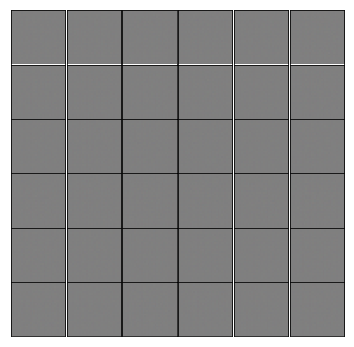

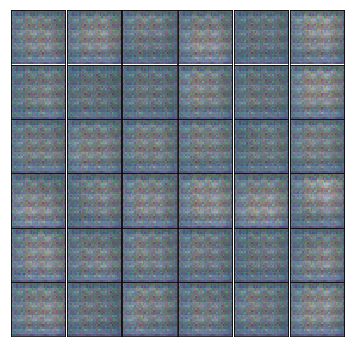

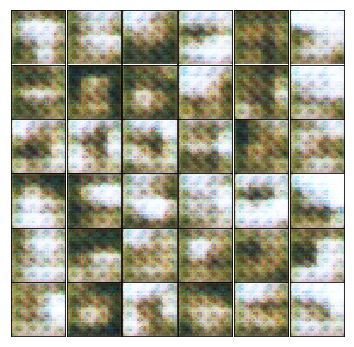

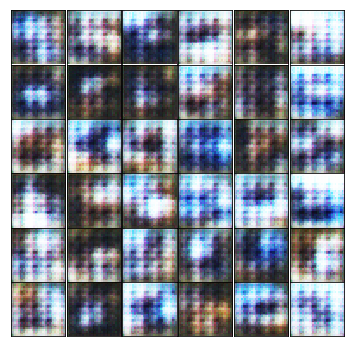

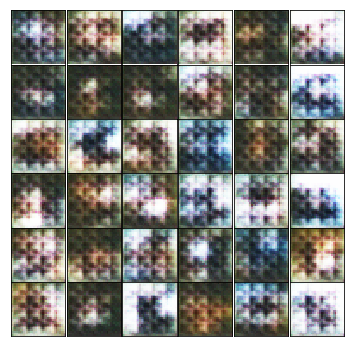

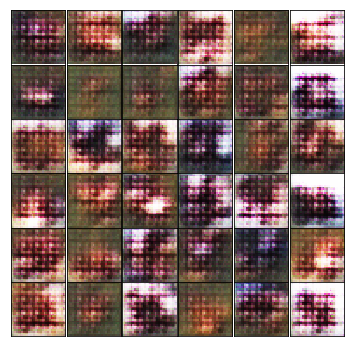

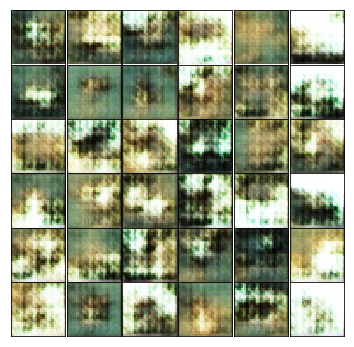

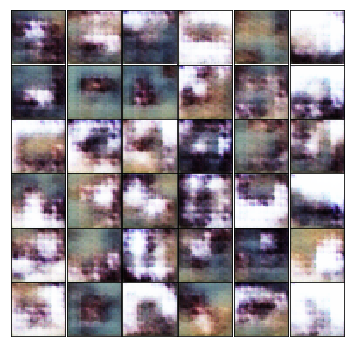

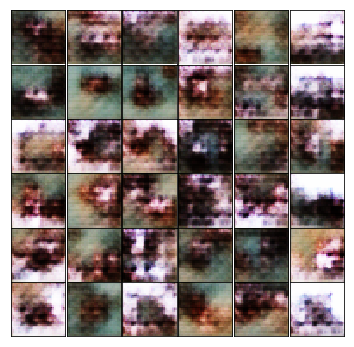

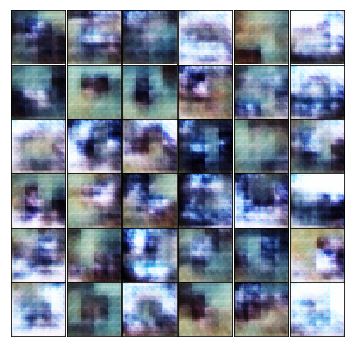

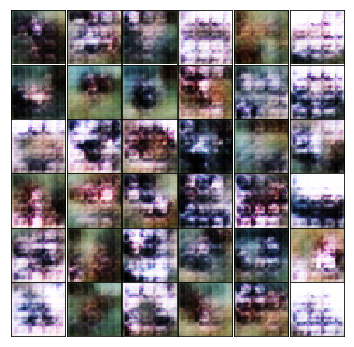

In [ ]:
# generate sample noise for evaluation
fake_input_test = tf.random_uniform(shape=(36, z_size),
                                 minval=-1.0, maxval=1.0, dtype=tf.float32)

for counter, (batch_real_images, batch_real_labels) in enumerate(train_dataset):
  fake_input = tf.random_uniform(shape=(batch_size, z_size),
                                 minval=-1.0, maxval=1.0, dtype=tf.float32)
  
  
  batch_real_images = tf.to_float(batch_real_images)
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    
    # run the generator with the random noise batch
    g_model = generator_net(fake_input, is_training=True)
    
    # run the discriminator with real input images
    d_logits_real = discriminator_net(batch_real_images, is_training=True)
      
    # run the discriminator with fake input images (images from the generator)
    d_logits_fake = discriminator_net(g_model, is_training=True)
    
    # compute the generator loss
    gen_loss = generator_loss(d_logits_fake)
    
    # compute the discriminator loss
    dis_loss = discriminator_loss(d_logits_real, d_logits_fake)
    
    #print("Generator loss:", gen_loss, "Discriminator loss:", dis_loss)
   
  if counter % 300 == 0:
    generated_samples = generator_net(fake_input_test, is_training=False)
    display_images(generated_samples.numpy())
    
  discriminator_grads = d_tape.gradient(dis_loss, discriminator_net.variables)
  generator_grads = g_tape.gradient(gen_loss, generator_net.variables)
  
  discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator_net.variables), global_step=global_counter)
  generator_optimizer.apply_gradients(zip(generator_grads, generator_net.variables), global_step=global_counter)
  
  counter += 1